<a href="https://colab.research.google.com/github/Azie88/NLP-Huggingface-Covid-19-Tweet-Sentiment-Analysis/blob/main/dev/Tweet%20Sentiment%20Analysis%20Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with HuggingFace & Colab

Deep learning has pretty much taken over NLP. Language models like those available through huggingface are able to capture nuances of text, and can be trained with very little effort. They are super easy to use.

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps. It's really awesome.


The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. This project will use [Google Colab](https://colab.research.google.com/) to leverage the GPU computational power.

This project is about Natural Language Processing, specifically text classification (Sentiment analysis). In this project, we will fine-tune a pre-trained text classification Deep Learning model from HuggingFace on a new dataset to adapt the models to the task that we want to solve, i.e the prediction of the sentiment expressed in a Tweet (e.g: neutral, positive, negative), then create an app to use the models and deploy the app on the HuggingFace platform.

<br>

Read more about [Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

## Business Understanding

Vaccines have lowered the risk of illness and death, and have saved countless lives around the world. Unfortunately in some countries, the 'anti-vaxxer' movement has led to lower rates of vaccination and new outbreaks of old diseases.

The COVID vaccination has been very controversial and people have mixed feelings and opinions about it. Therefore, it is important to monitor public sentiment towards vaccinations now and in the future as the COVID-19 vaccines continue to be offered to the public. The anti-vaccination sentiment could pose a serious threat to the global efforts to get COVID-19 under control in the long term.

The objective of this challenge is to develop a machine learning model to assess if a Twitter post related to COVID vaccinations is positive, neutral, or negative. This solution could help governments and other public health actors monitor public sentiment towards COVID-19 vaccinations and help improve public health policy, vaccine communication strategies, and vaccination programs across the world.

## Data Understanding

### Install Libraries and Packages

In [4]:
!pip install datasets
!pip install accelerate>=0.20.1
!pip install transformers[torch]
!pip install -U huggingface_hub
!pip install tokenizers --upgrade
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 10.8 MB/s eta 0:00:00


### Import Libraries and Packages

In [5]:
#System and data handling
import os
import re
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np

#Data Preparation
from evaluate import load
from datasets import Dataset, DatasetDict

#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Google Drive
from google.colab import drive

#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

#Scores
from scipy.special import softmax

# Deep learning
import torch
from torch import nn

#Huggingface
from huggingface_hub import notebook_login

### Setup

In [7]:
#login to huggingface with access token

notebook_login()

In [8]:
# Set a fixed random seed for PyTorch on CPU
torch.manual_seed(42)

# Control the seed for individual GPU operations (optional)
if torch.cuda.is_available:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(42)


In [9]:
# Connect to your google drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

### Data Loading

In [11]:
# Load the dataset and display some values
df = pd.read_csv('/content/drive/MyDrive/Covid-19 tweet dataset/Train.csv')


In [12]:
#look at first 10 rows in train data
df.head(10)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.000000
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.000000
5,OVNPOAUX,<user> a nearly 67 year old study when mental health studies and vaccines were relatively in their infancies that has been refuted?,1.0,0.666667
6,JDA2QDV5,"Study of more than 95,000 kids finds no link between MMR vaccine and autism <url>",1.0,0.666667
7,S6UKR4OJ,psa: VACCINATE YOUR FUCKING KIDS,1.0,1.000000
8,V6IJATBE,Coughing extra on the shuttle and everyone thinks I have the measles. 😂 #VaccinateYourKids,1.0,0.666667
9,VB25IDQK,AIDS vaccine created at Oregon Health &amp; Science University may clear virus from body - <url> <url>,1.0,0.666667


1. **tweet_id**: Unique identifier of the tweet

2. **safe_tweet**: Text contained in the tweet. Some sensitive information has been removed like usernames and urls

3. **label**: Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)

4. **agreement**: The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.

In [13]:
#Check rows and columns
df.shape

(10001, 4)

In [14]:
#Check Data types
df.dtypes

,0
tweet_id,object
safe_text,object
label,float64
agreement,float64


In [15]:
#Descriptive Statistics
df.describe()

,label,agreement
count,10000.000000,9999.000000
mean,0.301567,0.854252
std,0.646718,0.180707
min,-1.000000,0.333333
25%,0.000000,0.666667
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [16]:
#Check Null values
df.isna().sum()

,0
tweet_id,0
safe_text,0
label,1
agreement,2


In [17]:
# Check the 'label' value counts
df.label.value_counts()

,count
label,
0.000000,4908
1.000000,4053
-1.000000,1038
0.666667,1


In [18]:
# Check for quality of 'safe_text' tweets
df.safe_text.sample(10)

,safe_text
7312,Just ran 3.204 <user> for <user> which means 8 more vaccinations have been funded for puppies &amp; kittens. Truth! #100helpfuldays
2767,<user> ahhhh!! I Wish. Home with kiddo. Client work and vaccines. :)
9259,WSU study: Emotional pitch to vaccine skeptics may backfire: Emotional messages and heart-tugging images of kids… <url>
7617,Brain cancer vaccine trial begins <url>\n#Health #BrainTumour #BrainCancer #Cancer #Oncology #Oncologist #Medicine
931,<user> NCAA tourney Edition.Hot-Faking measles.10minsAgo-Faking strep throat.Not-actually hurting back but get to watch games #Truth
4968,"speechless, met people that are proud for not vaccinating their kids as there is no scientific proof…"
8500,Wealthy communities tend to have higher rates of non-vaccinated kids; poor communities tend to be *under* vaccinated. #vaccineswork <user>
331,"Being FAKE is like dying of a slow death wit no vaccine, being REAL is eternal and healthy. Which dose have you taken today?"
90,<user> TY. Fought hard 2 NOT vaccinate my kids. Yrs of ppl's judgements. Don't get hurt; get smart
4350,"AIDS N : HIV, AIDS Cure &amp; Treatment: New Findings on Vaccine Response Out : Latinos Health News ...: LOS ANGELES,… <url>"


## Data Preparation

1. Remove rows with NaN values.
2. Clean *safe-text* column of Twitter Handles, HTML characters, URLs and other non alphabetic characters. Text is inconsistent and may affect model performance.

In [19]:
# Eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [20]:
# Check null values
df.isna().sum()

,0
tweet_id,0
safe_text,0
label,0
agreement,0


In [21]:
# Function to clean text
# Replace unwanted characters with empty string

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove tweet mentions
    text = re.sub(r'<user>', '', text)
    text = re.sub(r'<url>', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

In [22]:
# Apply the clean_text function to the 'safe_text' column
df['safe_text'] = df.safe_text.apply(clean_text)

In [23]:
df.safe_text.sample(20)

,safe_text
9304,RT NIH halts HIV vaccine trial LGBT Gay GayHealth Health AIDS
2574,The Magic School Bus told kids to get their shots in the third episode Love that show and please vaccinate your kids srsly plzzzz
1216,GOP STOP blaming Immigrants first Ebola now measles Which diseasesbrought their ancestors AINF
9037,Every seconds a child dies from a vaccinepreventable disease Help expand access to vaccines globally in the budget
4537,NY Health Dept Measles patient boarded Amtrak train at Penn Station
1336,MeaslesOutbreak Please immunize your children I remember having to be quarantined no vaccine when I was a child
4821,African Nations Celebrate a Percent Drop in Child Mortality Rates Due to Immunization
5534,Nurse Nancy at the Weekly Breakfast Club on the issue of the need for vaccinations and the recent measles outbreak
3545,Outbreak of measles In this date and age This is a good time to stress the importance of vaccinations WorldAutismAwarenessDay liub
9336,Six MonthOld Baby Dies Just Five Days After Receiving Vaccines They say its just COINCIDENCE


In [24]:
# Check label value counts after deleting NaN values
df.label.value_counts()

,count
label,
0.0,4908
1.0,4053
-1.0,1038


The target classes are imbalanced.

### Exploratory Data Analysis

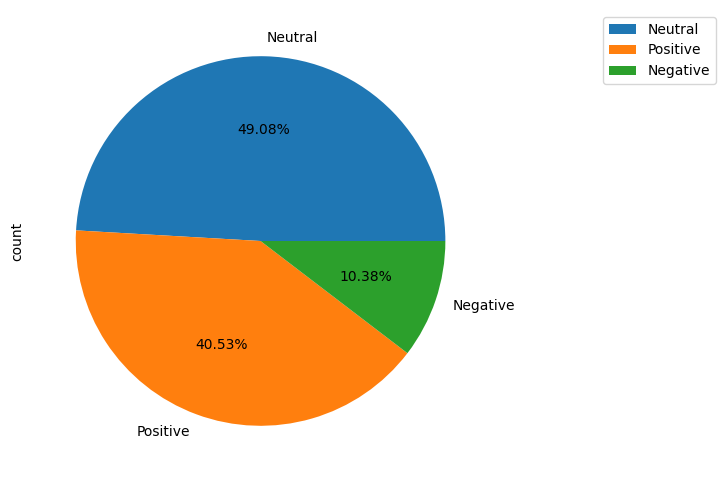

In [25]:
# pie chart wth 'labels' column
plt.figure(figsize=(6,6))
explode=0.1,0
df.label.value_counts().plot.pie(autopct='%1.2f%%',labels=['Neutral','Positive','Negative'])
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

Neutral and positive sentiments are more prevalent, while negative sentiments are relatively less frequent in the dataset.

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

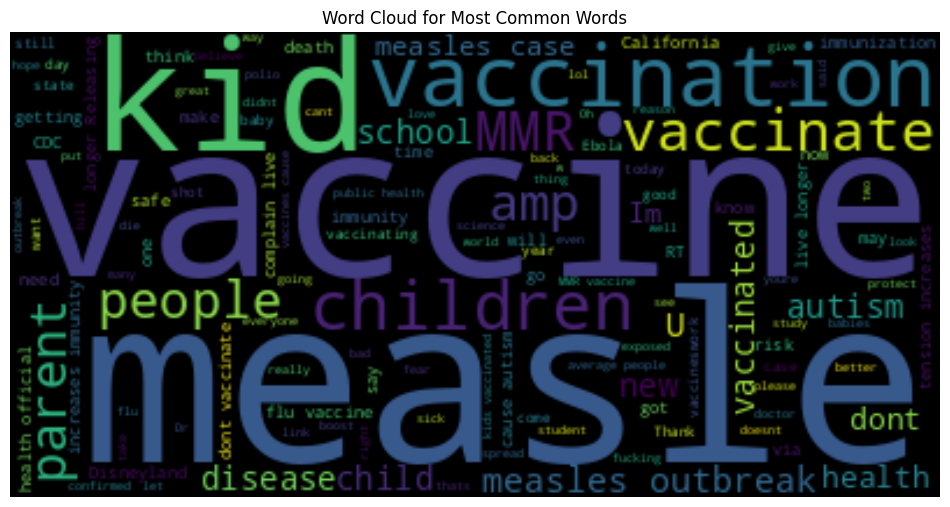

In [26]:
#generate a word cloud visualization from the 'safe_text' column

all_data = df['safe_text'].to_string()
wordcloud = WordCloud().generate(all_data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Word Cloud for Most Common Words')
plt.axis("off")

The word cloud provides a visual representation of the most frequent terms in the tweets. The size of each word in the cloud is proportional to its frequency. Lets look at how many words are in each tweet.

In [27]:
# Number of words in each tweet in the 'safe_text' column
text_lengths = df['safe_text'].str.split().str.len()
text_lengths.value_counts().sort_values(ascending=False)

,count
safe_text,
16,789
17,711
18,669
15,653
13,636
14,580
19,565
10,522
11,502


In [28]:
# Calculate the average
average_length = np.mean(text_lengths)

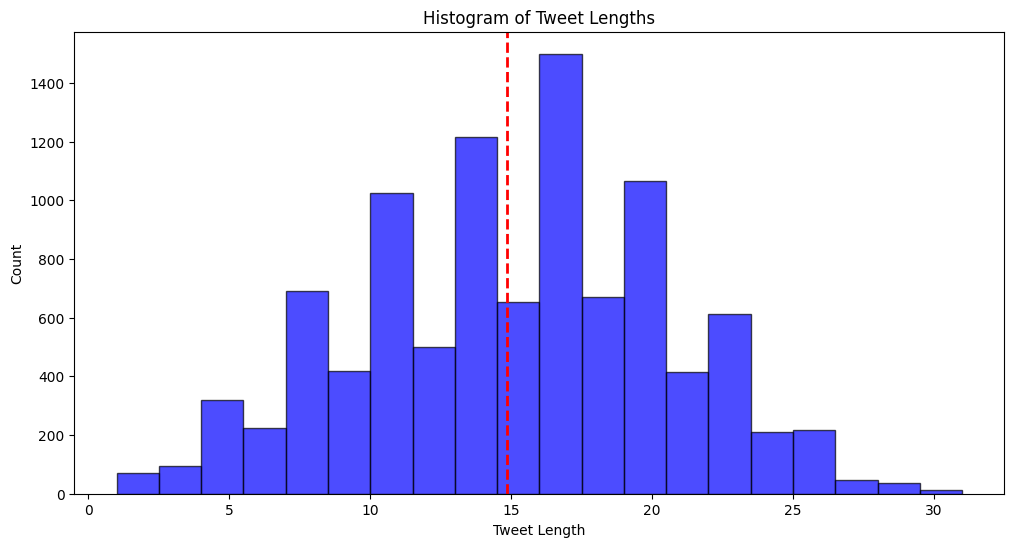

In [29]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Using plt.hist to create a histogram with Matplotlib
ax.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)

# Add average line
ax.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')

ax.set_title('Histogram of Tweet Lengths')
ax.set_xlabel('Tweet Length')
ax.set_ylabel('Count')

# Display the plot
plt.show()


### Train Test Split

In [30]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [31]:
#preview the train subset
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickeys Measles has gone international,0.0,1.000000
3907,5GV8NEZS,S NEW Extends exemption from charitable immunity for certain civil actions to persons of any age who are be,0.0,1.000000
795,EI10PS46,your ignorance on vaccines isnt just dangerous to your innocent child but to others around you Shame on you,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination program after terrorists kill health workers,0.0,1.000000
3431,NBBY86FX,In other news Ive gone up like mmr,0.0,1.000000


In [32]:
#preview the eval subset
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Childrens Museum of Houston to Offer Free Vaccinations,1.0,1.000000
1754,2DD250VN,no I was properly immunized prior to the performance The kid puts on a legit show I will say,1.0,1.000000
3325,ESEVBTFN,thx for posting vaccinations are imperative A dear puppy I know died of Parvo a terrible death Humans wise up,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vaccinate via,1.0,0.666667
4175,IIN5D33V,Meeting tonight pm in room of the student center kent ksu kentstate immunizations ChildrenFirst,1.0,1.000000


In [33]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [34]:
# Save split subsets
train.to_csv("/content/drive/MyDrive/Covid-19 tweet dataset/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Covid-19 tweet dataset/eval_subset.csv", index=False)

## Model Fine Tuning and Training

In [35]:
# Define pre-trained model name and instance of tokenizer from the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

**Model**: Twitter-roBERTa-base for Sentiment Analysis - UPDATED (2022) [Model link on huggingface](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

**Description**: This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark.

**Labels**:
*   Negative --> 0
*   Neutral --> 1
*   Positive --> 2




In [36]:
# Function to transform the labels:
# Negative -1:0
# Neutral 0:1
# Positive 1:2

def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [37]:
# Convert dataframes to datasets objects
train_dataset = Dataset.from_pandas(train)
eval_dataset = Dataset.from_pandas(eval)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})

In [40]:
# Function to tokenize data

def tokenize_data(example):
    return tokenizer(example['safe_text'], max_length = 128, padding='max_length', truncation=True)

In [41]:
# Change the tweets to tokens that the model can use
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

#### Balancing Target Classes

Since our target has imbalanced class weights (positive, neutral and negative dont have an equal number of samples), we want to give more weight to underrepresented classes and give less weight to classes with more samples.

In [43]:
# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

The `balanced` option in compute_class_weight will calculate weights such that the classes are balanced.

In [44]:
# Preview class weights
class_weights, np.unique(labels)

(array([3.20858404, 0.67914756, 0.82243471]), array([0, 1, 2]))

In [45]:
# Define an instance of the pre-trained model with the number of labels
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# Configure the training parameters

training_args = TrainingArguments("./results",
    num_train_epochs=5, # the number of times the model will repeat the training loop over the dataset
    load_best_model_at_end=True,
    eval_strategy='epoch',
    save_strategy='epoch',)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [48]:
# evaluation metrics

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [49]:
# Instantiate the training and validation sets with random state of 10
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [50]:
# Convert train data to PyTorch tensors to speed up training and add padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding=True, max_length='max_length', return_tensors='pt')

In [54]:
# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure logits and labels have compatible shapes and labels are of integer type
        #assert logits.shape[1] == self.model.config.num_labels, f"Logits shape {logits.shape} does not match number of labels {self.model.config.num_labels}"
        #assert labels.max() < self.model.config.num_labels, f"Labels contain values outside the valid range: {labels}"
        #assert labels.dtype == torch.long, f"Labels must be of type torch.long, but got {labels.dtype}"

        # Apply Class Weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(model.device)

        # Compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [55]:
# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer = tokenizer,
                  compute_metrics=compute_metrics,
)

<ipython-input-55-a18fe7ae74a2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  c_trainer = CustomTrainer(


In [56]:
# Launch the learning process: training
c_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.746600,0.719797,0.777500
2,0.566300,0.768961,0.773000
3,0.436600,0.967065,0.787500
4,0.294700,1.290407,0.797500
5,0.192700,1.508038,0.792500


TrainOutput(global_step=5000, training_loss=0.4575707168579102, metrics={'train_runtime': 1133.5674, 'train_samples_per_second': 35.282, 'train_steps_per_second': 4.411, 'total_flos': 2630805285507840.0, 'train_loss': 0.4575707168579102, 'epoch': 5.0})

`Training Loss`: The training loss is decreasing with each epoch, which is a positive sign. It suggests that the model is learning and improving its predictions on the training data.

`Validation Loss`: The validation loss is relatively stable for the first 3 epochs but starts to increase thereafter. This could indicate overfitting, where the model is performing well on the training data but not generalizing as effectively on evaluation(unseen) data.

`Accuracy`: The accuracy on the validation data is around 78% in the final epoch, which is a reasonable accuracy. The model is correctly predicting sentiments for approximately 78% of the validation samples.

In [57]:
# Launch the final evaluation
c_trainer.evaluate()

{'eval_loss': 0.7197967767715454,
 'eval_accuracy': 0.7775,
 'eval_runtime': 12.7756,
 'eval_samples_per_second': 156.548,
 'eval_steps_per_second': 19.568,
 'epoch': 5.0}

In [58]:
# Push model and tokenizer to HF Hub
model.push_to_hub("Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta")
tokenizer.push_to_hub("Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta")
dataset.push_to_hub("Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

## Inference
Let's test out our model with with some sample text

In [59]:
model_path = f"Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [60]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [61]:
# Input preprocessing
text = "Covid vaccine is very effective"
text = preprocess(text)

In [62]:
# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [63]:
print("Scores:", scores)
print("id2label Dictionary:", config.id2label)


Scores: [0.06562514 0.05804993 0.8763249 ]
id2label Dictionary: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [64]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [65]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) POSITIVE 0.8763
2) NEGATIVE 0.0656
3) NEUTRAL 0.058
